In [96]:
from osgeo import gdal, gdalconst, gdal_array
from PIL import Image
import pylab as plt
import matplotlib.image as mpimg
import csv
import numpy as np
import geopandas as gpd
from sklearn.model_selection import KFold 
from sklearn import cross_validation
import matplotlib.patches as mpatches
%matplotlib inline

#### Import and inspect the satellite data

In [2]:
inputfile = 'data/houston/h_small_2.tif'

dataset = gdal.Open(inputfile, gdal.GA_ReadOnly)

# How many bands does this image have?
num_bands = dataset.RasterCount
rows = dataset.RasterYSize
cols = dataset.RasterXSize
print('Number of bands in image: {n}'.format(n=num_bands))
print('Image size is: {r} rows x {c} columns'.format(r=rows, c=cols))

Number of bands in image: 12
Image size is: 1050 rows x 1784 columns


In [3]:
# Initialize a 3d array -- size based on raster dimensions
image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount))

# Allocate array using the first band's datatype
image_datatype = dataset.GetRasterBand(1).DataType

image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# Loop over all bands in dataset

for b in range(dataset.RasterCount):
    # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
    band = dataset.GetRasterBand(b + 1)
    
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()

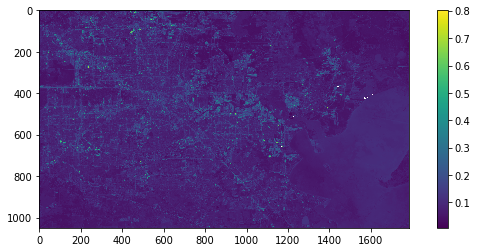

In [6]:
ax = plt.figure(figsize=(10,4))
plt.imshow(image[:,:,2])
plt.colorbar()

#### Read in the training image

In [110]:
# Read in Houston training image
#training_input = 'data/houston/land_2015_raster.tif'
training_input = 'data/houston/training_projected.tif'
resampled_input = 'data/houston/h_resampled_clips_trainin.tif'

houston_read = gdal.Open(resampled_input, gdal.GA_ReadOnly)

h_train = np.zeros((houston_read.RasterYSize, houston_read.RasterXSize),
               gdal_array.GDALTypeCodeToNumericTypeCode(houston_read.GetRasterBand(1).DataType))
h_train = houston_read.ReadAsArray()

#### Note, the classes are:
0: open water
1: developed high intensity
2: developed med intensity
3: developed low intensity
4: developed open space
5-10: barren, forest, pasture, crops, wetlands

We want to reclass as:

0: open water
1: developed high and med intensity
2: developed low intensity and developed open space
3: non-urban land

In [111]:
# Reclass the pixels in our new categories

category_dict = {0:255, 1:1, 2:2, 3:2, 4:3, 5:3, 6:4, 7:4, 8:4, 9:4, 10:4, 255:255}

h_train_cat = np.vectorize(category_dict.get)(h_train.reshape(-1,1))

# Reshape the categorized image to its proper x,y shape
h_train_cat=h_train_cat.reshape(h_train.shape)
print(h_train_cat.shape)

(1050, 1784)


In [113]:
# See the new unique values

classes = np.unique(h_train_cat)
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(h_train_cat == c).sum()))

Class 1 contains 324218 pixels
Class 2 contains 438295 pixels
Class 3 contains 479183 pixels
Class 4 contains 631066 pixels
Class 255 contains 438 pixels


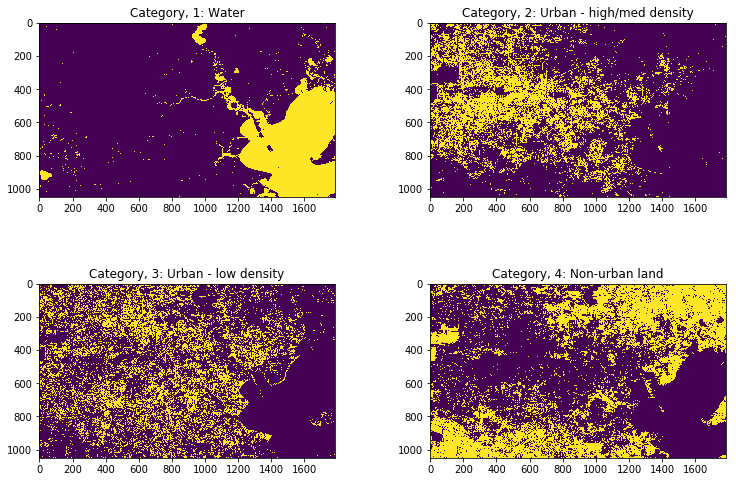

In [117]:
# Visualize categorized training image from its np array
fig, axs = plt.subplots(2,2, figsize=(14, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

titles=['1: Water','2: Urban - high/med density','3: Urban - low density',
      '4: Non-urban land']

for i in range(4):

    axs[i].imshow(h_train_cat==i+1)
    axs[i].set_title("Category, "+titles[i])

#### Sync up the satellite and training sets
First clip the training data to the satellite data's bounding box

In [118]:
print('satellite: ',image.shape)
print("train: ",h_train_cat.shape)

('satellite: ', (1050, 1784, 12))
('train: ', (1050, 1784))


In [81]:
smaller_raster = gdal.Open(inputfile)
larger_raster  = gdal.Open('data/houston/land_2015_raster.tif')

# given that a geotransform object is in this form:
#adfGeoTransform[0] /* top left x */
#adfGeoTransform[1] /* w-e pixel resolution */
#adfGeoTransform[2] /* 0 */
#adfGeoTransform[3] /* top left y */
#adfGeoTransform[4] /* 0 */
#adfGeoTransform[5] /* n-s pixel resolution (negative value) */

gt = smaller_raster.GetGeoTransform()
lt = houston_read.GetGeoTransform()
print(gt)
print
print(lt)
print

SmlMaxX = gt[0] + (gt[1] * smaller_raster.RasterXSize)
SmlMinY = gt[3] + (gt[5] * smaller_raster.RasterYSize)
Xoff = int((gt[0] - lt[0])/lt[1]) # cols to skip
Yoff = int((gt[3] - lt[3])/lt[5]) # rows to skip
Cols = int((SmlMaxX - gt[0])/lt[1])
Rows = int((SmlMinY - gt[3])/lt[5])

# print out some numbers so you can check manually
print("X offset {}, Y offset {}".format(Xoff,Yoff))
print("Xmax {}, Ymin {}".format(SmlMaxX,SmlMinY))
print("Reading {} cols, {} rows".format(Cols,Rows))

band = houston_read.GetRasterBand(1)
train_clipped = houston_read.ReadAsArray(Xoff,Yoff,Cols,Rows) # read the larger raster

(-95.66734382370622, 0.0005389891704717129, 0.0, 29.98612351002328, 0.0, -0.0005389891704717129)

(-96.90184321825704, 0.0002981352124011445, 0.0, 31.087803479924787, 0.0, -0.0002981352124011443)

X offset 4140, Y offset 3695
Xmax -94.7057871436, Ymin 29.420184881
Reading 3225 cols, 1898 rows


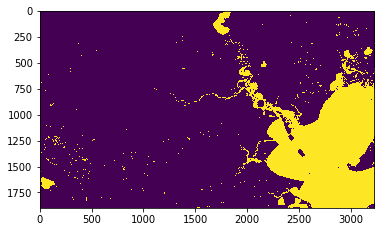

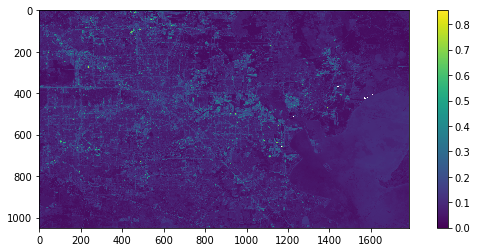

In [90]:
# Read the clipped data into array

#train_clipped = np.zeros((data.RasterYSize, data.RasterXSize),
#               gdal_array.GDALTypeCodeToNumericTypeCode(data.GetRasterBand(1).DataType))
#train_clipped = data.ReadAsArray()
train_clipped.shape
#image.shape
plt.imshow(train_clipped==1)

ax = plt.figure(figsize=(10,4))
plt.imshow(image[:,:,3])
plt.colorbar()
print("OK they're covering the same geographic area! But at different resolutions.")

In [72]:
# OK so we have to run the categorization again:

# Reclass the pixels in our new categories

category_dict = {0:255, 1:1, 2:2, 3:2, 4:3, 5:3, 6:4, 7:4, 8:4, 9:4, 10:4, 255:255}

train_clipped_cat = np.vectorize(category_dict.get)(train_clipped.reshape(-1,1))

# Reshape the categorized image to its proper x,y shape
train_clipped_cat=train_clipped_cat.reshape(train_clipped.shape)
print(train_clipped_cat.shape)

(84269621, 1)


In [ ]:
# Visualize categorized training image from its np array
fig, axs = plt.subplots(2,2, figsize=(12, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

titles=['1: Water','2: Urban - high/med density','3: Urban - low density',
      '4: Non-urban land']

for i in range(4):

    axs[i].imshow(train_clipped==i+1)
    axs[i].set_title("Category, "+titles[i])

In [101]:
# Try this code instead

input = gdal.Open(inputfile, gdal.GA_ReadOnly)
inputProj = input.GetProjection()
inputTrans = input.GetGeoTransform()

referencefile = 'data/houston/clipped_Houston_training.tif'
reference = gdal.Open(referencefile, gdal.GA_ReadOnly)
referenceProj = reference.GetProjection()
referenceTrans = reference.GetGeoTransform()
bandreference = reference.GetRasterBand(1)    
x = reference.RasterXSize 
y = reference.RasterYSize

outputfile = 'data/houston/resampled_training.tif'
driver= gdal.GetDriverByName('GTiff')
output = driver.Create(outputfile,x,y,1,bandreference.DataType)
output.SetGeoTransform(referenceTrans)
output.SetProjection(referenceProj)

gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)

del output

# OK that didn't work

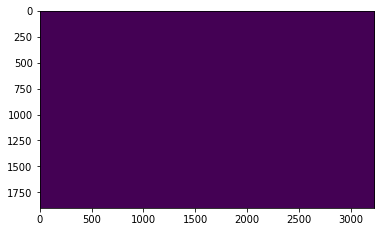

In [107]:
plt.imshow(h_train==3)